In [2]:
import numpy as np
from matplotlib import pyplot as plt
import imageio
import json
import os
import skimage.color as color
from math import log10
from skimage.metrics import peak_signal_noise_ratio as compute_psnr
from skimage.metrics import structural_similarity as compute_ssim
from utils import compute_auc, compute_lpips
from tqdm import tqdm
from contextlib import contextmanager
import sys
from scipy.stats.stats import pearsonr
print(sys.executable)

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

            
def get_args(method_name):
    if 'OUR' in method_name:
        print(os.path.join(path,method_name+'output',method_name+'args.txt'))
        with open(os.path.join(path,method_name+'output',method_name+'args.txt'), "r") as read_file:
            args_train = json.load(read_file)
    else:
        print(os.path.join(path,method_name+'args.txt'))
        with open(os.path.join(path,method_name+'args.txt'), "r") as read_file:
            args_train = json.load(read_file)
    print(method_name, 'training params:', args_train)

experiment_list = ['col_bedroom', 'col_church',
                  'denblind_bedroom', 'denblind_church', 'denblind_conference',
                  'inpcrop_bedroom', 'inpcrop_church', 'inpcrop_conference',
                  'inpvar_bedroom', 'inpvar_church', 'inpvar_conference',
                  'inprand_bedroom', 'inprand_church', 'inprand_conference',
                  'inpmask_bedroom', 'inpmask_church', 'inpmask_conference']

/ivrldata1/home/elhelou/anaconda3/envs/mGAN/bin/python


### Print all train logs and MSE test results

In [138]:
test_ID = '0'
train_on_train = True

print(f'** results of test model {test_ID}, with training on train: {train_on_train} **')
for exp in experiment_list:

    if train_on_train:
        exp += '_train'
    test_model = exp + '_' + test_ID
    print(f'\n- {exp} -')
    train_loss = np.load(os.path.join('../net_data',test_model,'train_loss.npy'))
    Mphi = np.load(os.path.join('../net_data',test_model,'Mphi.npy'))
    MSE = np.load(os.path.join('../net_data',test_model,'MSE.npy'))
    MSE_GAN = np.load(os.path.join('../net_data',test_model,'MSE_GAN.npy'))
    if 'col' in test_model:
        AUC = np.load(os.path.join('../net_data',test_model,'AUC.npy'))
        AUC_GAN = np.load(os.path.join('../net_data',test_model,'AUC_GAN.npy'))

    print(f'Mean Phi: {Mphi.mean():.4f}')
    if 'col' in test_model:
        print(f'mGAN AuC: {AUC_GAN.mean():.4f}, OUR AuC: {AUC.mean():.4f}')
    print(f'mGAN MSE: {MSE_GAN.mean():.6f}, OUR MSE: {MSE.mean():.6f}')

#     plt.plot(train_loss[2:-1]); plt.title('Training loss vs epochs'); plt.show()


** results of test model 0, with training on train: True **

- col_bedroom_train -
Mean Phi: 0.6091
mGAN AuC: 90.5669, OUR AuC: 91.8519
mGAN MSE: 0.005357, OUR MSE: 0.004225

- col_church_train -
Mean Phi: 0.6320
mGAN AuC: 89.1287, OUR AuC: 89.9657
mGAN MSE: 0.008254, OUR MSE: 0.007056

- denblind_bedroom_train -
Mean Phi: 0.7288
mGAN MSE: 0.005309, OUR MSE: 0.003232

- denblind_church_train -
Mean Phi: 0.7390
mGAN MSE: 0.007941, OUR MSE: 0.004055

- denblind_conference_train -
Mean Phi: 0.6357
mGAN MSE: 0.006376, OUR MSE: 0.003741

- inpcrop_bedroom_train -
Mean Phi: 0.1707
mGAN MSE: 0.006682, OUR MSE: 0.002424

- inpcrop_church_train -
Mean Phi: 0.1221
mGAN MSE: 0.009629, OUR MSE: 0.003430

- inpcrop_conference_train -
Mean Phi: -0.1643
mGAN MSE: 0.008580, OUR MSE: 0.004548

- inpvar_bedroom_train -
Mean Phi: 0.5889
mGAN MSE: 0.009378, OUR MSE: 0.007602

- inpvar_church_train -
Mean Phi: 0.0846
mGAN MSE: 0.012832, OUR MSE: 0.008818

- inpvar_conference_train -
Mean Phi: 0.0375
mGAN M

### Visualize and assess image test results in inter_data

In [4]:
experiments_col = ['col_bedroom', 'col_church']
experiments_inpcrop = ['inpcrop_bedroom', 'inpcrop_church', 'inpcrop_conference']
experiments_denblind = ['denblind_bedroom', 'denblind_church', 'denblind_conference']
experiments_inpvar = ['inpvar_bedroom', 'inpvar_church', 'inpvar_conference']
experiments_inpmask = ['inpmask_bedroom', 'inpmask_church', 'inpmask_conference']
experiments_inprand = ['inprand_bedroom', 'inprand_church', 'inprand_conference']
os.system("export XDG_CACHE_HOME=../cache/")
##################################
test_IDs = range(250,300)
train_on_train = False
display_images = 0
experiments = experiments_denblind
##################################

psnr_mean_glob = np.zeros(2)
ssim_mean_glob = np.zeros(2)
auc_mean_glob = np.zeros(2)
lpips_mean_glob = np.zeros(2)
phi_glob = np.zeros(2)
results_dncnn_glob = np.zeros(3)
results_dfill_glob = np.zeros(3)
auc_string_gan = ''
auc_string_our = ''

for experiment in experiments:
    
    if train_on_train:
        experiment += '_train'
    path = f'../inter_data/{experiment}/'
    _ = get_args('mGAN')
    args_train = get_args('OUR')

    plt.rcParams["figure.figsize"] = (20,5)
    psnr_gan = []; psnr_our = []; psnr_dncnn = []; psnr_dfill = []
    ssim_gan = []; ssim_our = []; ssim_dncnn = []; ssim_dfill = []
    auc_gan = [];  auc_our = []
    phi_mean = []; phi_std  = []
    lpips_gan = []; lpips_our = []; lpips_dncnn = []; lpips_dfill = []
    
    for ID in tqdm(test_IDs):
        # Loading images
        if 'den' in experiment:
            inp_path = path+f'input/{ID}.npy'
            inp = np.load(inp_path)
            dncnn_path = path+f'DnCNNoutput/{ID}.png'
            dncnn = imageio.imread(dncnn_path)
            with open(os.path.join('..','inter_data',experiment,'input', 'sigma.json')) as read_file:
                sigma = json.load(read_file)
        else:
            if 'inp' in experiment:
                dfill_path = path+f'deepfill/{ID}.png'
                dfill = imageio.imread(dfill_path)
            inp_path = path+f'input/{ID}.png'
            inp = imageio.imread(inp_path)
        gt_path = path+f'GT/{ID}.png'
        gt = imageio.imread(gt_path)
        gan_path = path+f'mGANoutput/{ID}.png'
        gan = imageio.imread(gan_path)
        our_path = path+f'OURoutput/{ID}.png'
        our = imageio.imread(our_path)
        phi_path = path+f'OURoutput/{ID}_phi.png'
        phi = imageio.imread(phi_path)

        # Computing metrics
        psnr_gan.append(compute_psnr(gt,gan,data_range=255)); psnr_our.append(compute_psnr(gt,our,data_range=255))
        ssim_gan.append(compute_ssim(gt,gan,data_range=255,multichannel=True)); ssim_our.append(compute_ssim(gt,our,data_range=255,multichannel=True))
        phi_mean.append(phi.mean()/255.); phi_std.append((phi/255.).std())
        if 'den' in experiment:
            psnr_dncnn.append(compute_psnr(gt,dncnn,data_range=255))
            ssim_dncnn.append(compute_ssim(gt,dncnn,data_range=255,multichannel=True))
        if 'inp' in experiment:
            psnr_dfill.append(compute_psnr(gt,dfill,data_range=255))
            ssim_dfill.append(compute_ssim(gt,dfill,data_range=255,multichannel=True))
            
        if not display_images:
            with suppress_stdout():
                lpips_gan.append(compute_lpips(gt_path,gan_path)); lpips_our.append(compute_lpips(gt_path,our_path))
                if 'den' in experiment:
                    lpips_dncnn.append(compute_lpips(gt_path,dncnn_path))
                if 'inp' in experiment:
                    lpips_dfill.append(compute_lpips(gt_path,dfill_path))
        if 'col' in experiment:
            auc_gan.append(compute_auc(gt,gan)); auc_our.append(compute_auc(gt,our))
            auc_string_gan = f' {compute_auc(gt,gan):.2f}'
            auc_string_our = f' {compute_auc(gt,our):.2f}'

        # Displaying visual results
        if display_images:
            if 'den' in experiment or 'inp' in experiment:
                fig, axs = plt.subplots(1,6)
            else:
                fig, axs = plt.subplots(1,5)
            axs[0].imshow(gt); axs[0].axis('off'); axs[0].set_title(f'GT img {ID}')
            if 'den' in experiment:
                axs[1].imshow(inp, cmap='gray'); axs[1].axis('off');  axs[1].set_title(f'Input ($\sigma=${sigma[ID]})')
            else:
                axs[1].imshow(inp, cmap='gray'); axs[1].axis('off');  axs[1].set_title(f'Input')
            axs[2].imshow(gan); axs[2].axis('off'); axs[2].set_title(f'GAN ({psnr_gan[-1]:.2f}, {ssim_gan[-1]:.2f})'+auc_string_gan)
            axs[3].imshow(our); axs[3].axis('off'); axs[3].set_title(f'OUR ({psnr_our[-1]:.2f}, {ssim_our[-1]:.2f})'+auc_string_our)
            img = axs[4].imshow(phi.mean(2)/255., cmap='inferno'); axs[4].axis('off'); axs[4].set_title(f'$\phi$  ({phi_mean[-1]:.2f}, {phi_std[-1]:.2f})'); #fig.colorbar(img)
            if 'den' in experiment:
                axs[5].imshow(dncnn); axs[5].axis('off'); axs[5].set_title(f'DnCNN ({psnr_dncnn[-1]:.2f}, {ssim_dncnn[-1]:.2f})')
            if 'inp' in experiment:
                axs[5].imshow(dfill); axs[5].axis('off'); axs[5].set_title(f'Dfill ({psnr_dfill[-1]:.2f}, {ssim_dfill[-1]:.2f})')
            plt.show()
            
            # UNcomment to save external phi *average*, comment the above plotting, and edit rcparams to (5,5)
#             os.makedirs(path+f'phi_mean', exist_ok=True)
#             plt.imshow(phi.mean(2), cmap='inferno'); plt.axis('off')
#             plt.savefig(path+f'phi_mean/{ID}_phi.png', dpi=200)
#             plt.show()

    psnr_mean = [sum(psnr_gan)/len(test_IDs), sum(psnr_our)/len(test_IDs)]
    ssim_mean = [sum(ssim_gan)/len(test_IDs), sum(ssim_our)/len(test_IDs)]
    auc_mean = [sum(auc_gan)/len(test_IDs), sum(auc_our)/len(test_IDs)]
    lpips_mean = [sum(lpips_gan)/len(test_IDs), sum(lpips_our)/len(test_IDs)]
    phi = [sum(phi_mean)/len(test_IDs), sum(phi_std)/len(test_IDs)]
    
    if 'den' in experiment:
        results_dncnn = [sum(psnr_dncnn)/len(test_IDs), sum(ssim_dncnn)/len(test_IDs), sum(lpips_dncnn)/len(test_IDs)]
    if 'inp' in experiment:
        results_dfill = [sum(psnr_dfill)/len(test_IDs), sum(ssim_dfill)/len(test_IDs), sum(lpips_dfill)/len(test_IDs)]
    
    # Computing averages across datasets per experiment
    psnr_mean_glob[0] += psnr_mean[0]/len(experiments); psnr_mean_glob[1] += psnr_mean[1]/len(experiments)
    ssim_mean_glob[0] += ssim_mean[0]/len(experiments); ssim_mean_glob[1] += ssim_mean[1]/len(experiments)
    auc_mean_glob[0] += auc_mean[0]/len(experiments); auc_mean_glob[1] += auc_mean[1]/len(experiments)
    lpips_mean_glob[0] += lpips_mean[0]/len(experiments); lpips_mean_glob[1] += lpips_mean[1]/len(experiments)
    phi_glob[0] += phi[0]/len(experiments); phi_glob[1] += phi[1]/len(experiments)
    
    if 'den' in experiment:
        for i in range(3): #PSNR-SSIM-LPIPS
            results_dncnn_glob[i] += results_dncnn[i]/len(experiments)
        print(f'DnCNN results on {experiment}: \nPSNR: {results_dncnn[0]:.2f}  SSIM: {results_dncnn[1]:.4f}  LPIPS: {results_dncnn[2]:.4f}')
    if 'inp' in experiment:
        for i in range(3): #PSNR-SSIM-LPIPS
            results_dfill_glob[i] += results_dfill[i]/len(experiments)
        print(f'Deepfill results on {experiment}: \nPSNR: {results_dfill[0]:.2f}  SSIM: {results_dfill[1]:.4f}  LPIPS: {results_dfill[2]:.4f}')
        
    print(f'Results on {experiment}: \nPSNR: ({psnr_mean[0]:.2f} & {psnr_mean[1]:.2f})  SSIM: ({ssim_mean[0]:.4f} & {ssim_mean[1]:.4f})  AuC: ({auc_mean[0]:.2f} & {auc_mean[1]:.2f})  LPIPS: ({lpips_mean[0]:.4f} & {lpips_mean[1]:.4f})')
    print(f'And for our method, $\phi$ (mean,std): ({phi[0]:.2f} & {phi[1]:.2f})')

print(f'\nMean results for {experiments}: \nPSNR ({psnr_mean_glob[0]:.2f} & {psnr_mean_glob[1]:.2f})  SSIM ({ssim_mean_glob[0]:.4f} & {ssim_mean_glob[1]:.4f})  AuC ({auc_mean_glob[0]:.2f} & {auc_mean_glob[1]:.2f})  LPIPS ({lpips_mean_glob[0]:.4f} & {lpips_mean_glob[1]:.4f})')
print(f'And for our method, $\phi$ (mean,std): ({phi_glob[0]:.2f} & {phi_glob[1]:.2f})')
print('DeepFill', results_dfill_glob)

  0%|          | 0/50 [00:00<?, ?it/s]

../inter_data/denblind_bedroom/mGANargs.txt
mGAN training params: {'target_images': 'data/lsun/data/bedroom', 'mask': './examples/masks/mask-2.png', 'outputs': 'inter_data/denblind_bedroom', 'inversion_type': 'PGGAN-Multi-Z', 'composing_layer': 4, 'z_number': 30, 'image_size': 256, 'loss_type': 'Combine', 'vgg_loss_type': 'L1', 'vgg_layer': 16, 'l1_lambda': 0.0, 'l2_lambda': 1.0, 'vgg_lambda': 0.1, 'batch_size': 1, 'optimization': 'GD', 'init_type': 'Normal', 'lr': 1.0, 'iterations': 3000, 'gan_model': 'pggan_bedroom', 'video': False, 'fps': 24, 'single_level': False, 'sigma_min': 5, 'sigma_max': 50}
../inter_data/denblind_bedroom/OURoutput/OURargs.txt
OUR training params: {'experiment': 'denblind_bedroom', 'extend_input': False, 'backbone': 'D', 'dncnn_layers': 17, 'memnet_channels': 5, 'memnet_memblocks': 5, 'memnet_resblocks': 5, 'batch_size': 8, 'epochs': 50, 'lr': 0.01, 'phi_weight': 1e-05, 'train_count': 250, 'test': True, 'test_model': 1, 'test_epoch': 24, 'test_data': 'Default'

  0%|          | 0/50 [00:00<?, ?it/s]

DnCNN results on denblind_bedroom: 
PSNR: 24.96  SSIM: 0.5804  LPIPS: 0.1859
Results on denblind_bedroom: 
PSNR: (22.72 & 26.80)  SSIM: (0.6257 & 0.7279)  AuC: (0.00 & 0.00)  LPIPS: (0.1978 & 0.0998)
And for our method, $\phi$ (mean,std): (0.62 & 0.21)
../inter_data/denblind_church/mGANargs.txt
mGAN training params: {'target_images': 'data/lsun/data/church', 'mask': './examples/masks/mask-2.png', 'outputs': 'inter_data/denblind_church', 'inversion_type': 'PGGAN-Multi-Z', 'composing_layer': 4, 'z_number': 30, 'image_size': 256, 'loss_type': 'Combine', 'vgg_loss_type': 'L1', 'vgg_layer': 16, 'l1_lambda': 0.0, 'l2_lambda': 1.0, 'vgg_lambda': 0.1, 'batch_size': 1, 'optimization': 'GD', 'init_type': 'Normal', 'lr': 1.0, 'iterations': 3000, 'gan_model': 'pggan_churchoutdoor', 'video': False, 'fps': 24, 'single_level': False, 'sigma_min': 5, 'sigma_max': 50}
../inter_data/denblind_church/OURoutput/OURargs.txt
OUR training params: {'experiment': 'denblind_church', 'extend_input': False, 'backb

  0%|          | 0/50 [00:00<?, ?it/s]

DnCNN results on denblind_church: 
PSNR: 22.40  SSIM: 0.5166  LPIPS: 0.2046
Results on denblind_church: 
PSNR: (21.12 & 23.38)  SSIM: (0.5643 & 0.5959)  AuC: (0.00 & 0.00)  LPIPS: (0.2065 & 0.1435)
And for our method, $\phi$ (mean,std): (0.83 & 0.19)
../inter_data/denblind_conference/mGANargs.txt
mGAN training params: {'target_images': 'data/lsun/data/conference', 'mask': './examples/masks/mask-2.png', 'outputs': 'inter_data/denblind_conference', 'inversion_type': 'PGGAN-Multi-Z', 'composing_layer': 4, 'z_number': 30, 'image_size': 256, 'loss_type': 'Combine', 'vgg_loss_type': 'L1', 'vgg_layer': 16, 'l1_lambda': 0.0, 'l2_lambda': 1.0, 'vgg_lambda': 0.1, 'batch_size': 1, 'optimization': 'GD', 'init_type': 'Normal', 'lr': 1.0, 'iterations': 3000, 'gan_model': 'pggan_conferenceroom', 'video': False, 'fps': 24, 'single_level': False, 'sigma_min': 5, 'sigma_max': 50}
../inter_data/denblind_conference/OURoutput/OURargs.txt
OUR training params: {'experiment': 'denblind_conference', 'extend_in

100%|██████████| 50/50 [02:46<00:00,  3.33s/it]

DnCNN results on denblind_conference: 
PSNR: 22.81  SSIM: 0.5310  LPIPS: 0.2167
Results on denblind_conference: 
PSNR: (21.49 & 24.70)  SSIM: (0.5962 & 0.6578)  AuC: (0.00 & 0.00)  LPIPS: (0.1968 & 0.1192)
And for our method, $\phi$ (mean,std): (0.71 & 0.22)

Mean results for ['denblind_bedroom', 'denblind_church', 'denblind_conference']: 
PSNR (21.78 & 24.96)  SSIM (0.5954 & 0.6605)  AuC (0.00 & 0.00)  LPIPS (0.2004 & 0.1208)
And for our method, $\phi$ (mean,std): (0.72 & 0.20)
DeepFill [0. 0. 0.]


### (AWGN) Analyzing the correlation between test sigma and test phi

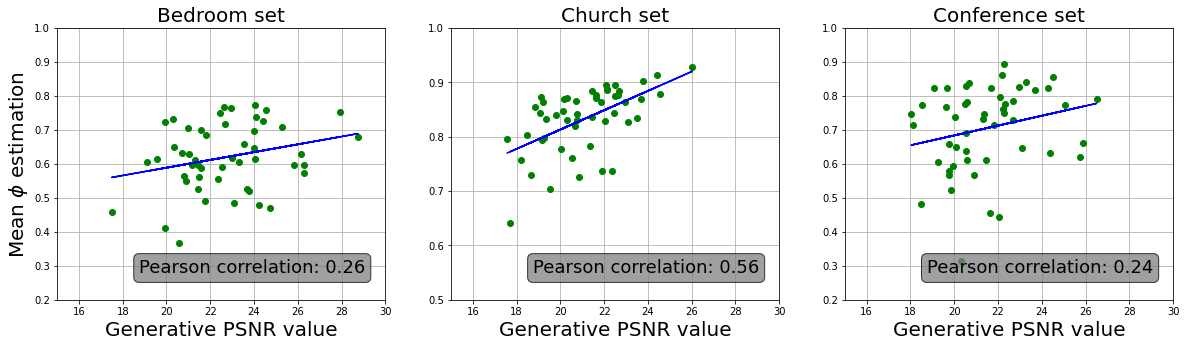

In [177]:
experiments_denblind = ['denblind_bedroom', 'denblind_church', 'denblind_conference']
plot_dataset_names = ['Bedroom', 'Church', 'Conference']
##################################
pearson_prior = True #True: correlation between phi&psnr, False: corr between phi&sigma
test_IDs = range(250,300)
experiments = experiments_denblind
##################################

psnr_mean_glob = np.zeros(2)
ssim_mean_glob = np.zeros(2)
phi_glob = np.zeros(2)

fig, axs = plt.subplots(1,3)

for idx, experiment in enumerate(experiments):
    
    path = f'../inter_data/{experiment}/'
    plt.rcParams["figure.figsize"] = (20,5)
    phi_mean = []; phi_std  = []
    psnr_gan = []
    
    with open(os.path.join('..','inter_data',experiment,'input', 'sigma.json')) as read_file:
        sigma = json.load(read_file)
    
    for ID in test_IDs:
        phi_path = path+f'OURoutput/{ID}_phi.png'
        phi = imageio.imread(phi_path)        
        phi_mean.append(phi.mean()/255.); phi_std.append((phi/255.).std())
        
        gt_path = path+f'GT/{ID}.png'
        gt = imageio.imread(gt_path)
        gan_path = path+f'mGANoutput/{ID}.png'
        gan = imageio.imread(gan_path)
        psnr_gan.append(compute_psnr(gt,gan,data_range=255));
        
        
    if pearson_prior:
        x = np.array(psnr_gan)
        axs[idx].set_xlim([15,30])
        axs[idx].set_xlabel('Generative PSNR value', fontsize=20)
    else:
        x = np.array(sigma[250:])
        axs[idx].set_xlim([5,50])
        axs[idx].set_xlabel('$\sigma$ of the test AWGN', fontsize=20)
        
        
    y = np.array(phi_mean)
    coef = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coef) 
    axs[idx].plot(x,y, 'go', x, poly1d_fn(x), 'b'); axs[idx].grid()
    if idx==1:
        axs[idx].set_ylim([0.5,1])
    else:
        axs[idx].set_ylim([0.2,1])
    if idx==0:
        axs[idx].set_ylabel('Mean $\phi$ estimation', fontsize=20)
    axs[idx].set_title(f'{plot_dataset_names[idx]} set', fontsize=20)
    axs[idx].text(0.25, 0.15,f'Pearson correlation: {pearsonr(x,y)[0]:.2f}', transform=axs[idx].transAxes, fontsize=18,
    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='gray', alpha=0.75))

if pearson_prior:
    plt.savefig('../figures/phi_corr_psnr.png', dpi=250)
else:
    plt.savefig('../figures/phi_corr_sigma.png', dpi=250)
plt.show()


#### INTERFACING WITH COLORFUL IMAGE COLORIZATION CAFFE

In [39]:
# (1) deactivate all envs\conda, go to python2.7 default install
#     import os
#     import sys
#     caffe_root = '/usr/local/caffee-gpu'
#     sys.path.insert(0, os.path.join(caffe_root, 'python'))
#     import caffe
# (2) cd to code/colorization/colorization/
# (3) run colorize with out_name
# python2.7 colorize.py -img_in ../../../inter_data/col_bedroom/input/263.png -img_out 263
# python2.7 colorize.py -img_in ../../../inter_data/col_church/input/260.png -img_out 260

image = np.load('colorization/colorization/263.npy')
gt_path = f'../inter_data/col_bedroom/GT/263.png'
gt = imageio.imread(gt_path)
auc = compute_auc(gt,image)
print(auc)
plt.imsave('../figures/263_cic.png', image, dpi=250)

image = np.load('colorization/colorization/260.npy')
gt_path = f'../inter_data/col_church/GT/260.png'
gt = imageio.imread(gt_path)
auc = compute_auc(gt,image)
print(auc)
plt.imsave('../figures/260_cic.png', image, dpi=250)


90.70330810546875
94.16768391927083
